In [65]:
#Importing libraries
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import copy

1. Finding of the Ground Truth Correspondence and matching the pixels

*****************Pixel Matching****************************


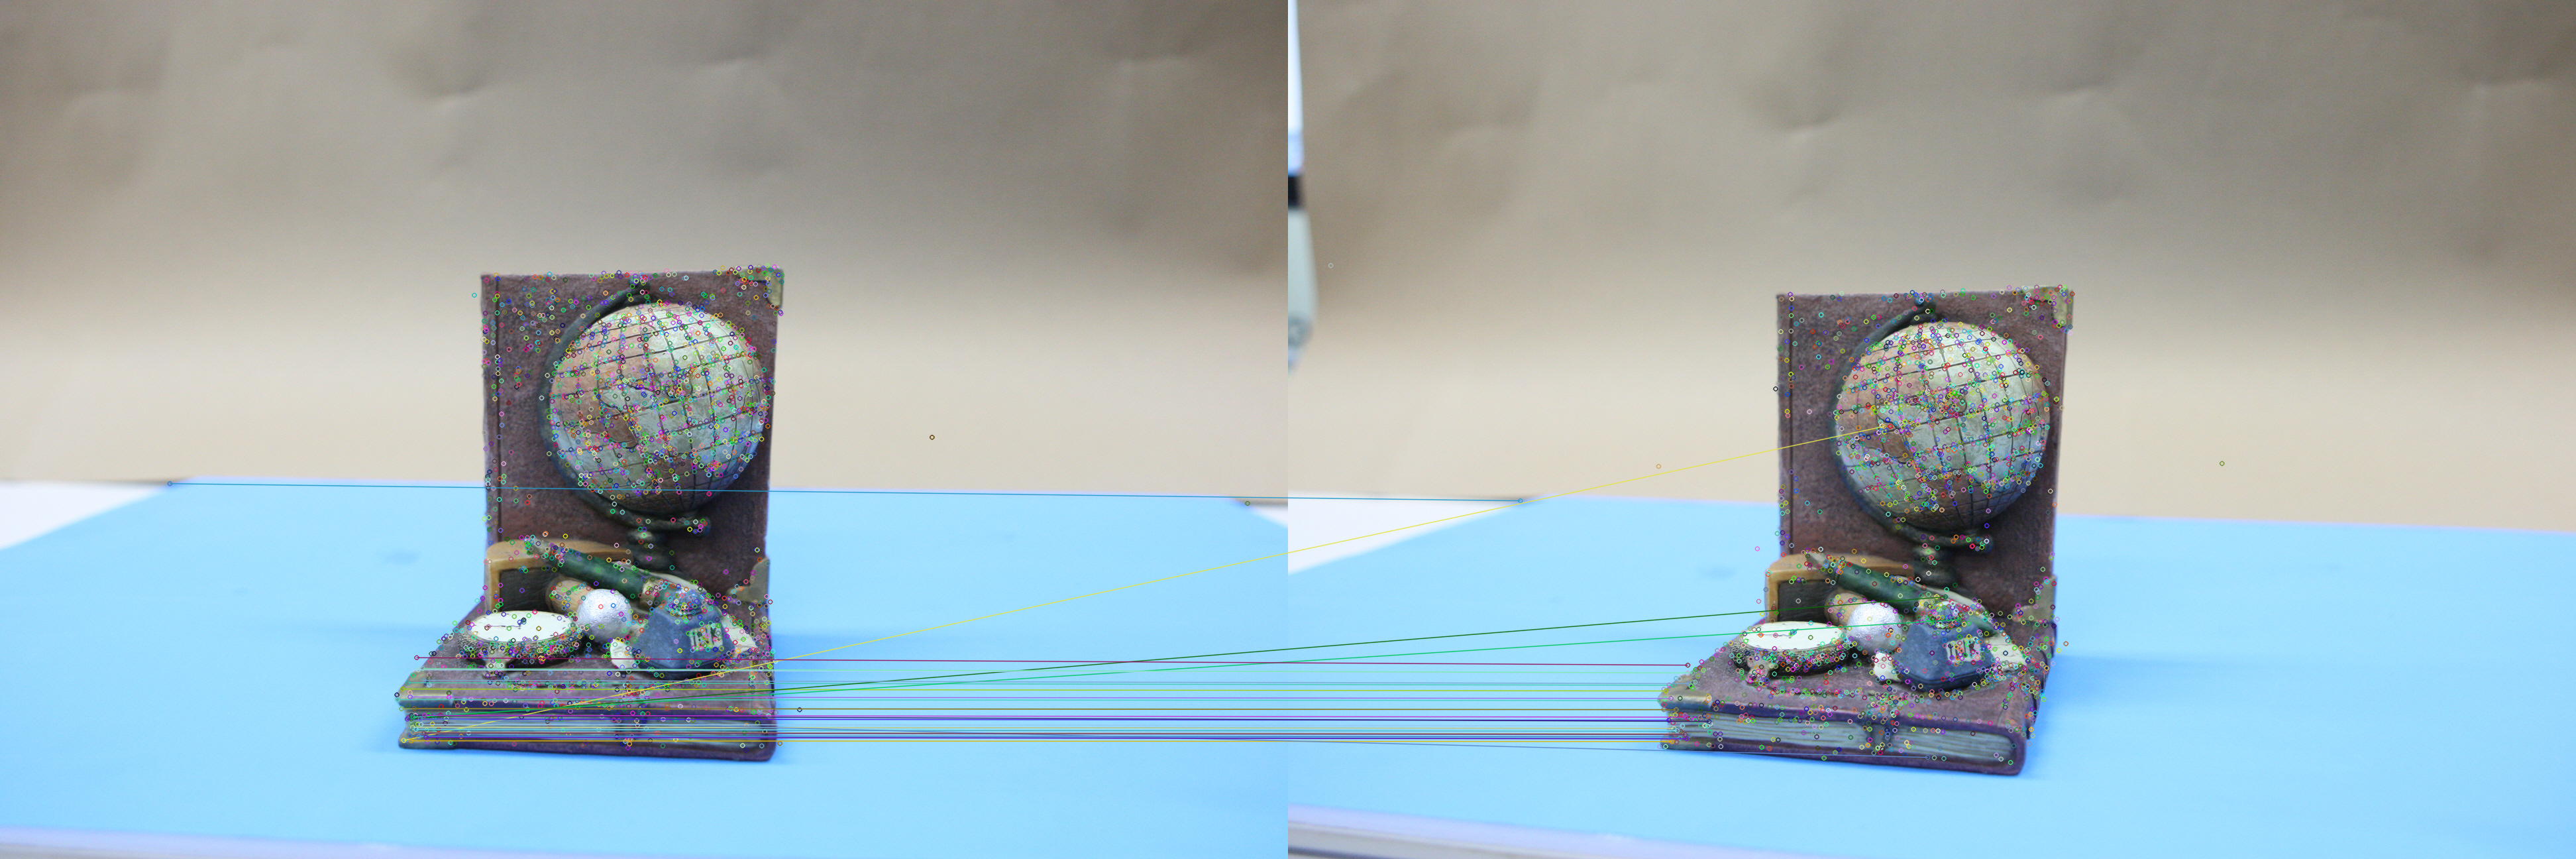

*****************Ground Truth Correspondence***************************
[[ 255.85559082  729.19793701]
 [ 599.54510498 1055.02429199]
 [ 605.5369873  1068.88513184]
 ...
 [1178.21630859  472.66467285]
 [1179.25732422  424.72357178]
 [1406.4029541   659.28466797]] [[ 350.19042969  755.10083008]
 [ 560.20849609 1056.46191406]
 [ 566.78411865 1070.04162598]
 ...
 [ 782.38555908  850.27386475]
 [1144.61279297 1007.54241943]
 [1409.26501465  698.83410645]]
n =  1797


In [66]:
#reading the images
image1, image2 = cv.imread("/content/im1.jpg"), cv.imread("/content/im2.jpg")
#the K matrix in array
K = np.array([[1698.873755, 0.000000,    971.7497705],
    [0.000000,    1698.8796645, 647.7488275],
    [0.000000,    0.000000,     1.000000]])
#using the sift library for feature matching
sift = cv.xfeatures2d.SIFT_create()

keypoints1, des1= sift.detectAndCompute(image1, None)
keypoints2, des2= sift.detectAndCompute(image2, None)

matches = cv.BFMatcher(cv.NORM_L1, crossCheck=True).match(des1,des2)

matched_img = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches[:30], None)

print('*****************Pixel Matching****************************')
cv2_imshow(matched_img)
#new array pi, p2 for storing the correspondence points
p1=[]
p2=[]
for match in matches:
  p1.append(keypoints1[match.queryIdx].pt)
  p2.append(keypoints2[match.trainIdx].pt)
p1=np.array(p1)
p2=np.array(p2)
print('*****************Ground Truth Correspondence***************************')
print(p1, p2)
pixel_map=[]
for i in range(0,len(p1)):
  pixel_map.append([p1[i][1], p1[i][0], p2[i][1], p2[i][0]])
print('n = ', len(matches))

2. Finding the Essential Matrix

In [67]:
#stroing the correspondence points in pi_temp and p2_temp
p1_temp,p2_temp = p1,p2
  
Kinv = np.linalg.inv(K)
print('----------------------------K inverse----------------------------------')
print(Kinv)
#making the points homogeneous points by adding 1 in z axis by making into 3D
z = np.ones((1797,1))
p1_temp=np.append(p1_temp, z, axis=1)
p2_temp=np.append(p2_temp, z, axis=1)
#new empty arrays for storing xi and yi points
xi=[]
yi=[]
for i in p1_temp:
  xi.append(np.dot(Kinv, i))

for i in p2_temp:
  yi.append(np.dot(Kinv, i))
xi=np.array(xi)
yi=np.array(yi)
print('------------------------------xi---------------------------------------')  
print(xi)
print('------------------------------yi---------------------------------------')
print(yi)
#new empty array A for storing the matrix A
A=[]
for i in range(0, 1797):
  #multiplication of matrix yi transpose and p matrix
  A.append((xi[i][0]*yi[i][0], xi[i][1]*yi[i][0], yi[i][0], xi[i][0]*yi[i][1], xi[i][1]*yi[i][1], yi[i][1] ,  xi[i][0],xi[i][1]  ,1))
A=np.array(A)
print('------------------------------A----------------------------------------') 
print(A)
print('------------------------Essential Matrix-------------------------------') 
#using np.linalg.svd() for finding out the essential matrix
u, s, v = np.linalg.svd(A)
U, S, V = np.linalg.svd(np.reshape(v[:, 8], (3, 3)))
Essential_Matrix=U @ np.diag([*S[:2], 0]) @ V 
print(Essential_Matrix)

----------------------------K inverse----------------------------------
[[ 5.88625257e-04  0.00000000e+00 -5.71996458e-01]
 [ 0.00000000e+00  5.88623209e-04 -3.81279994e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
------------------------------xi---------------------------------------
[[-0.4213934   0.04794284  1.        ]
 [-0.21908907  0.23973179  1.        ]
 [-0.21556209  0.2478906   1.        ]
 ...
 [ 0.12153142 -0.1030586   1.        ]
 [ 0.12214419 -0.13127784  1.        ]
 [ 0.25584784  0.00679026  1.        ]]
------------------------------yi---------------------------------------
[[-0.36586553  0.06318988  1.        ]
 [-0.24224359  0.24057801  1.        ]
 [-0.23837301  0.24857134  1.        ]
 ...
 [-0.11146456  0.11921094  1.        ]
 [ 0.10175154  0.21178286  1.        ]
 [ 0.25753252  0.03006998  1.        ]]
------------------------------A----------------------------------------
[[ 0.15417332 -0.01754063 -0.36586553 ... -0.4213934   0.04794284
   1.       

3. Finding the Rotation Matrix and Translation Vector 

In [68]:
#computing the rotation matrix and translation vector by using the formula taught in class
W=np.array([[0,-1,0],
            [1,0,0],
            [0,0,1]])

U, S, V = np.linalg.svd(Essential_Matrix)
#calculation of R1, R2, T1, T2
R1, R2, T1, T2 = U @ W @ V, U @ W.transpose() @ V, U[::, 2], -U[::, 2]
print('------------------------------R1---------------------------------------') 
print(R1)
print('------------------------------R2---------------------------------------') 
print(R2)
print('------------------------------T1---------------------------------------') 
print(T1)
print('------------------------------T2---------------------------------------')
print(T2) 

------------------------------R1---------------------------------------
[[ 0.01010485 -0.16785126 -0.98576054]
 [-0.9962524  -0.08637678  0.00449548]
 [-0.0859014   0.98202088 -0.16809505]]
------------------------------R2---------------------------------------
[[-0.01106044  0.1774401   0.98406945]
 [ 0.99393324  0.10964833 -0.00859967]
 [-0.10942749  0.97800422 -0.17757637]]
------------------------------T1---------------------------------------
[0.0048918  0.01187211 0.99991756]
------------------------------T2---------------------------------------
[-0.0048918  -0.01187211 -0.99991756]


4. Finding P using the triangulation approach

In [69]:
#using traingular approach for finding out the P
pi = []
#calculation of projection matrix for camera 1
pi1_temp = K @ np.hstack((np.identity(3), np.array([0, 0, 0]).reshape(3, 1)))
#calculation of projection matric for camera 2
pi2_temp = K @ np.hstack((R1, T1.reshape(3, 1)))

print(f'Projection matrix for camera-1:\n{pi1_temp}')
print(f'Projection matrix for camera-2:\n{pi2_temp}')
for i in range(len(pixel_map)):
  A = np.asarray([pixel_map[i][0] * pi1_temp[2, :] - pi1_temp[1, :],
        pi1_temp[0, :] - pixel_map[i][1] * pi1_temp[2, :],
        pixel_map[i][2] * pi2_temp[2, :] - pi2_temp[1, :],
        pi2_temp[0, :] - pixel_map[i][3] * pi2_temp[2, :]]).reshape(4, 4)
  # print(A)
  #using linalv.svd to solve the AP=0 equation
  U, S, V = np.linalg.svd(A)
  pt = V[0:3, 3] / V[3, 3]
  #appending all the pt points into pi
  pi.append(pt)
pi=np.array(pi)
print(pi)

Projection matrix for camera-1:
[[1.69887376e+03 0.00000000e+00 9.71749770e+02 0.00000000e+00]
 [0.00000000e+00 1.69887966e+03 6.47748827e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
Projection matrix for camera-2:
[[-6.63077926e+01  6.69120456e+02 -1.83802904e+03  9.79980201e+02]
 [-1.74815547e+03  4.89359112e+02 -1.01246089e+02  6.67864705e+02]
 [-8.59013966e-02  9.82020878e-01 -1.68095049e-01  9.99917558e-01]]
[[ 0.06885794  0.26299302  0.23078098]
 [-0.11729772 -0.1707492   0.22255901]
 [-0.12346449 -0.1658155   0.22126707]
 ...
 [ 0.0604032  -0.06831293  0.08362789]
 [ 0.10214701  0.05963612 -0.09419094]
 [-0.02806493 -0.15868133 -0.21213601]]


5. Plotting P and camera center t

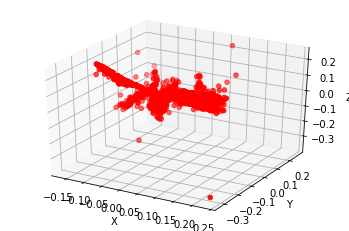

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z') 
ax.scatter(pi[:, 0], pi[:, 1], pi[:, 2], color='red')
plt.show()